In [10]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from math import sqrt, cos, radians
from scipy.spatial import Voronoi, voronoi_plot_2d

In [78]:
initial_data = pd.read_excel('data/initial_data.xlsx')

Подготовка данных

In [79]:
initial_data.drop(['Unnamed: 0', 'NEAR_Stations'], axis=1, inplace=True)
initial_data['NEAR_metro_rjd'].fillna(0, inplace=True)
initial_data['Avg_check'] = initial_data['value1'] / initial_data['value2']
initial_data['CITY'] = [w.lower() for w in initial_data['CITY']]

In [80]:
with open('data/coords.json', 'r') as dt:
    coords = json.loads(dt.read())
corrupted_coords = []
for k, v in coords.items():
    v[0] = float(v[0])
    v[1] = float(v[1])
    if v[1] < 33 or v[1] > 39 or v[0] > 55.3 or v[0] < 53:
        corrupted_coords.append(k)
initial_data['coords'] = initial_data['ADDRESS'].copy()
for addr in initial_data['ADDRESS']:
    if addr not in coords:
        corrupted_coords.append(addr)
initial_data['coords'] = initial_data['coords'].map(coords)

for row in initial_data.loc[initial_data.coords.isnull()].index:
    initial_data.at[row, 'coords'] = [0., 0.]

In [81]:
def havdist(lat1, lon1, lat2, lon2):
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    x = (lon2 - lon1) * cos(0.5 * (lat2 + lat1))
    y = lat2 - lat1
    return 6371 * sqrt(x**2 + y**2)

In [82]:
with open('data/competitors.json', 'r') as dt:
    competitors = json.loads(dt.read())
for k, v in competitors.items():
    v[0] = float(v[0])
    v[1] = float(v[1])
competitors = list(competitors.values())
coords = list(coords.values())

In [83]:
closest_post_coords = initial_data[((initial_data.Postamat_daily == initial_data.Postamat_daily) | (initial_data.cashbox_daily == initial_data.cashbox_daily))].coords

In [84]:
for i in range(initial_data.shape[0]):
    point = initial_data.loc[i].coords
    closest = 10000000
    for n in coords:
        dist = havdist(point[0], point[1], n[0], n[1])
        if dist >= 0.01:
            if dist < closest:
                closest = dist
    initial_data.at[i, 'dist_to_closest_shop'] = closest
    closest_post = 10000000
    for n in closest_post_coords:
        dist = havdist(point[0], point[1], n[0], n[1])
        if dist >= 0.01:
            if dist < closest_post:
                closest_post = dist
    initial_data.at[i, 'dist_to_closest_postomat'] = closest_post
    closest_comp = 100000000000
    for n in competitors:
        dist = havdist(point[0], point[1], n[0], n[1])
        if dist >= 0.01:
            if dist < closest_comp:
                closest_comp = dist
    initial_data.at[i, 'dist_to_competitor'] = closest_comp

In [85]:
with open('data/post_offices_coords.json', 'r') as dt:
    posts = json.loads(dt.read())
list(posts.values())
for i in range(initial_data.shape[0]):
    point = initial_data.loc[i].coords
    closest = 10000000
    for n in posts:
        dist = havdist(point[0], point[1], float(n[0]), float(n[1]))
        if dist >= 0.01:
            if dist < closest:
                closest = dist
    initial_data.at[i, 'dist_to_post'] = closest

In [86]:
stops = pd.read_csv('data/busses.csv', sep=';')
stops = stops.values

for i in range(initial_data.shape[0]): 
    point = initial_data.loc[i].coords
    closest = 1000000
    for n in stops:
        dist = havdist(point[0], point[1], n[0], n[1])
        if dist >= 0.01:
            if dist < closest:
                closest = dist
    initial_data.at[i, 'NEAR_stops'] = closest

Выбрасываем точки с некорректными координатами

In [87]:
for corr in corrupted_coords:
    initial_data = initial_data[initial_data.ADDRESS != corr]

In [88]:
initial_data.describe()

,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,macro_salary_avg_yearly,Avg_check,dist_to_closest_shop,dist_to_closest_postomat,dist_to_competitor,dist_to_post,NEAR_stops
count,71.000000,152.000000,71.000000,152.000000,139.000000,401.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,2.422535,1.370395,0.352113,7.190789,0.892086,2611.817955,10006.957711,2812.803483,152356.460199,0.106965,0.037313,0.024876,404436.059701,3.574546,2.114717,5.824255,16.842867,6752.207632,22.546580
std,1.283544,0.897667,0.481028,3.495946,0.311393,1972.798589,57.262755,203.584374,176596.476849,0.309454,0.189765,0.155940,17811.379489,0.235397,4.852327,11.282628,31.182228,51.230746,27.220268
min,1.000000,0.200000,0.000000,1.000000,0.000000,0.000000,9911.000000,2231.000000,119.000000,0.000000,0.000000,0.000000,387679.000000,2.898967,0.083041,0.083041,0.042063,6571.238654,0.021158
25%,2.000000,0.700000,0.000000,5.000000,1.000000,1067.000000,9956.250000,2680.000000,12392.000000,0.000000,0.000000,0.000000,387679.000000,3.431050,0.398464,0.473098,0.712507,6731.322851,0.280497
50%,2.000000,1.200000,0.000000,7.000000,1.000000,2191.000000,10003.500000,2786.000000,58139.000000,0.000000,0.000000,0.000000,387679.000000,3.588084,0.588204,0.849575,2.215477,6769.390936,1.335677
75%,3.000000,1.900000,1.000000,9.000000,1.000000,3620.000000,10056.750000,2930.500000,324698.000000,0.000000,0.000000,0.000000,423321.000000,3.723806,1.180776,3.956386,16.032903,6791.911916,41.153540
max,7.000000,4.800000,1.000000,19.000000,1.000000,9775.000000,10100.000000,3484.000000,482873.000000,1.000000,1.000000,1.000000,423321.000000,4.442403,35.171879,62.139183,157.847826,6838.208733,131.970961



---



Неравномерное распределение точек по городам 

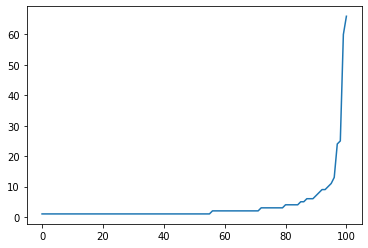

In [89]:
city_lens = sorted(dict(Counter(initial_data['CITY'])).values())
plt.plot(city_lens)

Матрица корреляции

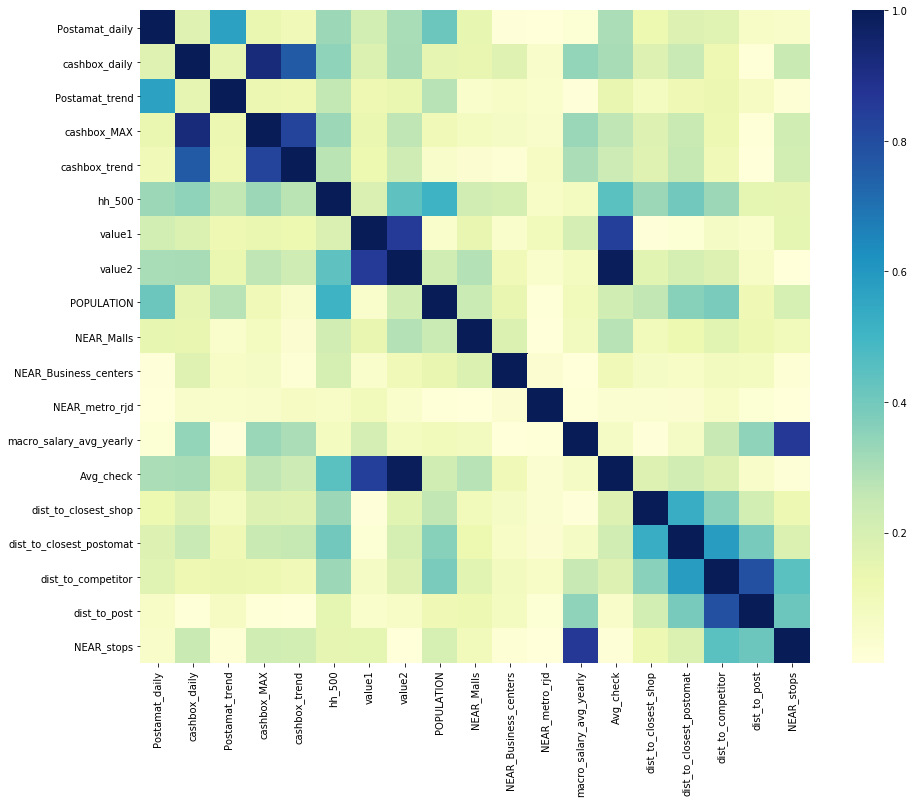

In [90]:
correl_data = initial_data.drop(['ADDRESS', 'CITY', 'REGION'], axis=1)
correl_data.fillna(0, inplace=True)
fig = plt.figure(figsize=(15, 12)) 
ax = plt.subplot()
ax = sns.heatmap(abs(correl_data.corr()), cmap="YlGnBu")

---


Диаграммы Вороного чтобы понять, где вот прям совсем плохо 

In [49]:
def voronoi_finite_polygons_2d(vor, radius=None):
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [50]:
def city_plot(city):
    points = initial_data[((initial_data.Postamat_daily == initial_data.Postamat_daily) | (initial_data.cashbox_daily == initial_data.cashbox_daily)) & (initial_data.CITY==city)]
    points = np.array(list(points['coords']))[:, ::-1]
    vor = Voronoi(points[::])

    regions, vertices = voronoi_finite_polygons_2d(vor)

    plt.figure(figsize=(8, 8))

    for region in regions:
        polygon = vertices[region]
        plt.fill(*zip(*polygon))

    plt.plot(points[:,0], points[:,1], 'ko')
    plt.xlim(vor.min_bound[0] - 0.01, vor.max_bound[0] + 0.01)
    plt.ylim(vor.min_bound[1] - 0.01, vor.max_bound[1] + 0.01)
    plt.show()
    
def city_plot_all(city):
    points = initial_data[initial_data.CITY==city]
    points = np.array(list(points['coords']))[:, ::-1]
    vor = Voronoi(points[::])

    regions, vertices = voronoi_finite_polygons_2d(vor)

    plt.figure(figsize=(8, 8))

    for region in regions:
        polygon = vertices[region]
        plt.fill(*zip(*polygon))

    plt.plot(points[:,0], points[:,1], 'ko')
    plt.xlim(vor.min_bound[0] - 0.01, vor.max_bound[0] + 0.01)
    plt.ylim(vor.min_bound[1] - 0.01, vor.max_bound[1] + 0.01)
    plt.show()

In [120]:
points = initial_data[(initial_data.Postamat_daily == initial_data.Postamat_daily) | (initial_data.cashbox_daily == initial_data.cashbox_daily)]
points = np.array(list(points['coords']))[:, ::-1]

Обе области

Можно увидеть, насколько одиноко между населенными городами

(53.044166, 55.298833)

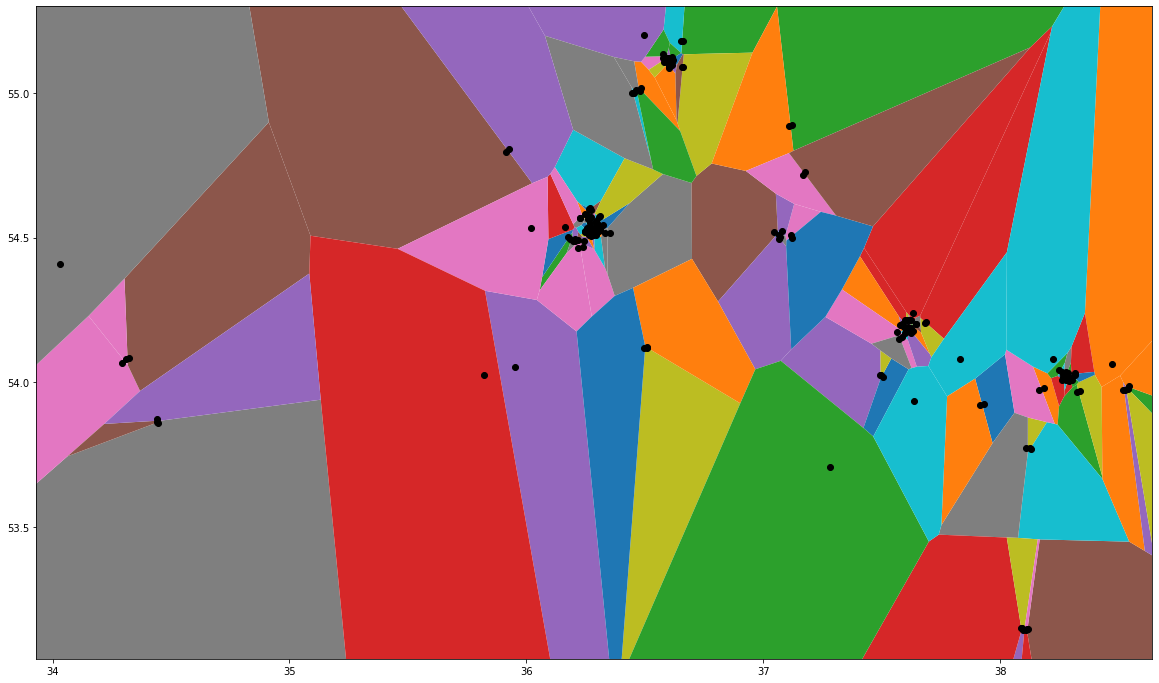

In [159]:
vor = Voronoi(points[::])

regions, vertices = voronoi_finite_polygons_2d(vor)

plt.figure(figsize=(20, 12))

for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon))
    
plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

График постоматов или выдач на кассе

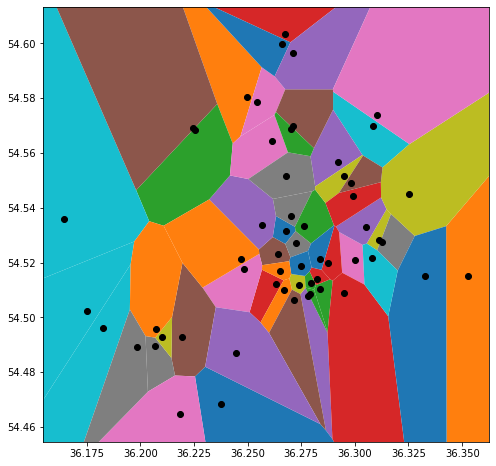

In [122]:
city_plot('калуга')

График просто точек - с постоматами или без

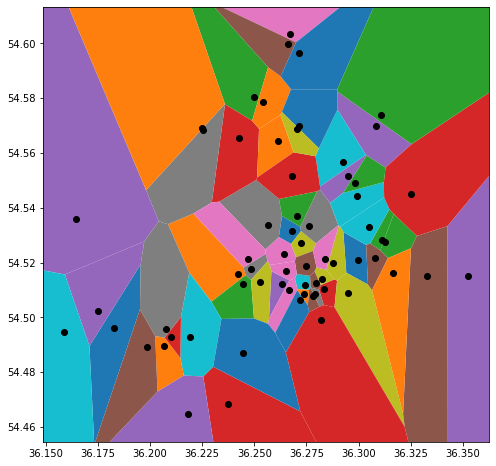

In [123]:
city_plot_all('калуга')

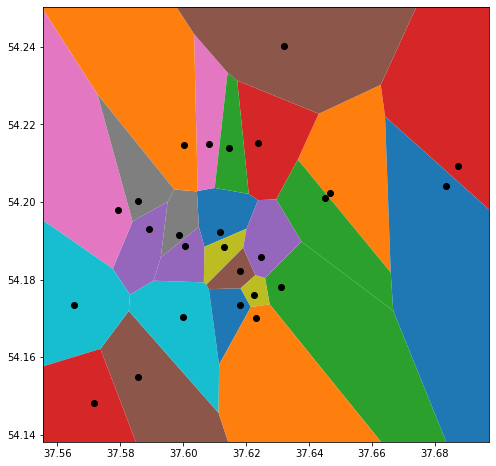

In [124]:
city_plot('тула')

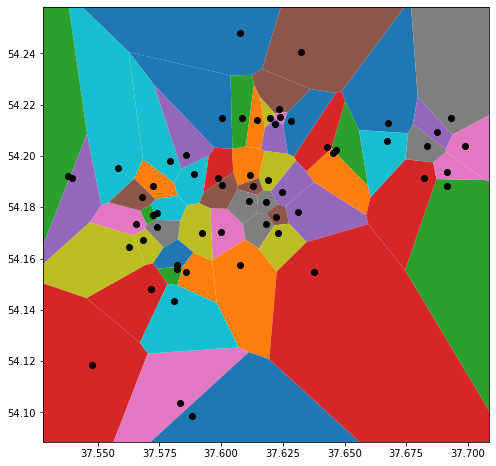

In [125]:
city_plot_all('тула')

In [91]:
initial_data.to_csv('data/reformatted_data.csv')